In [2]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [5]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [6]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [7]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 2000 Updates
global update: 100
mean batch reward: [4.65895097 3.2087379  4.5855272  4.31198078 5.30511011 3.842259
 3.57051647 5.09219138]
mean batch pF: [2.55724877 2.55481008 2.5550016  2.5569612  2.55207698 2.55072671
 2.55505931 2.54791511]
mean batch photon: [36.57660675 36.92779541 35.13080597 35.95717621 36.24552536 35.56681824
 36.04257965 34.66814804]
mean batch photon time: [0.37699054 0.37894149 0.37371282 0.38665847 0.36563668 0.37943585
 0.35951655 0.36092675]
mean batch smoothness: [0.00413497 0.00442654 0.00642387 0.00530315 0.00490693 0.00324267
 0.00361325 0.00454271]
max reward obtained: [19.64345594 20.12683317 19.05217456 21.04616651 18.76914509 20.19459789
 19.49862415 18.79719769]
pF at max: [2.55837783 2.56122067 2.55797686 2.56215959 2.56344305 2.53386179
 2.55906935 2.56065333]
photon at max: [32.97328186 37.09109116 36.32693481 34.65159225 38.97524643 28.15610695
 34.33030701 36.15620422]
photon time of max: [0.43868227 0.44881362 0.30514467

In [8]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

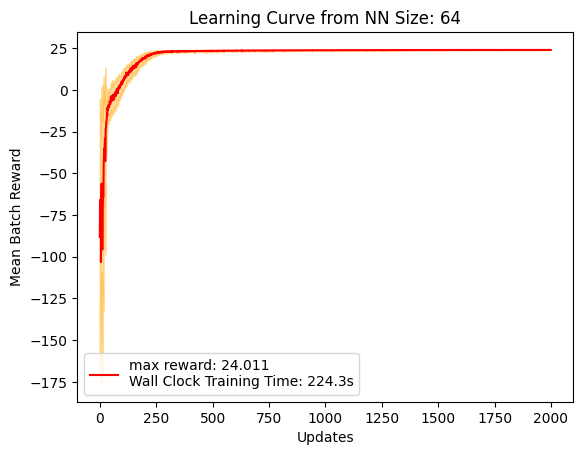

In [9]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 81)
0.08833333333333335
0.4386822661459876
0.16744582180222864


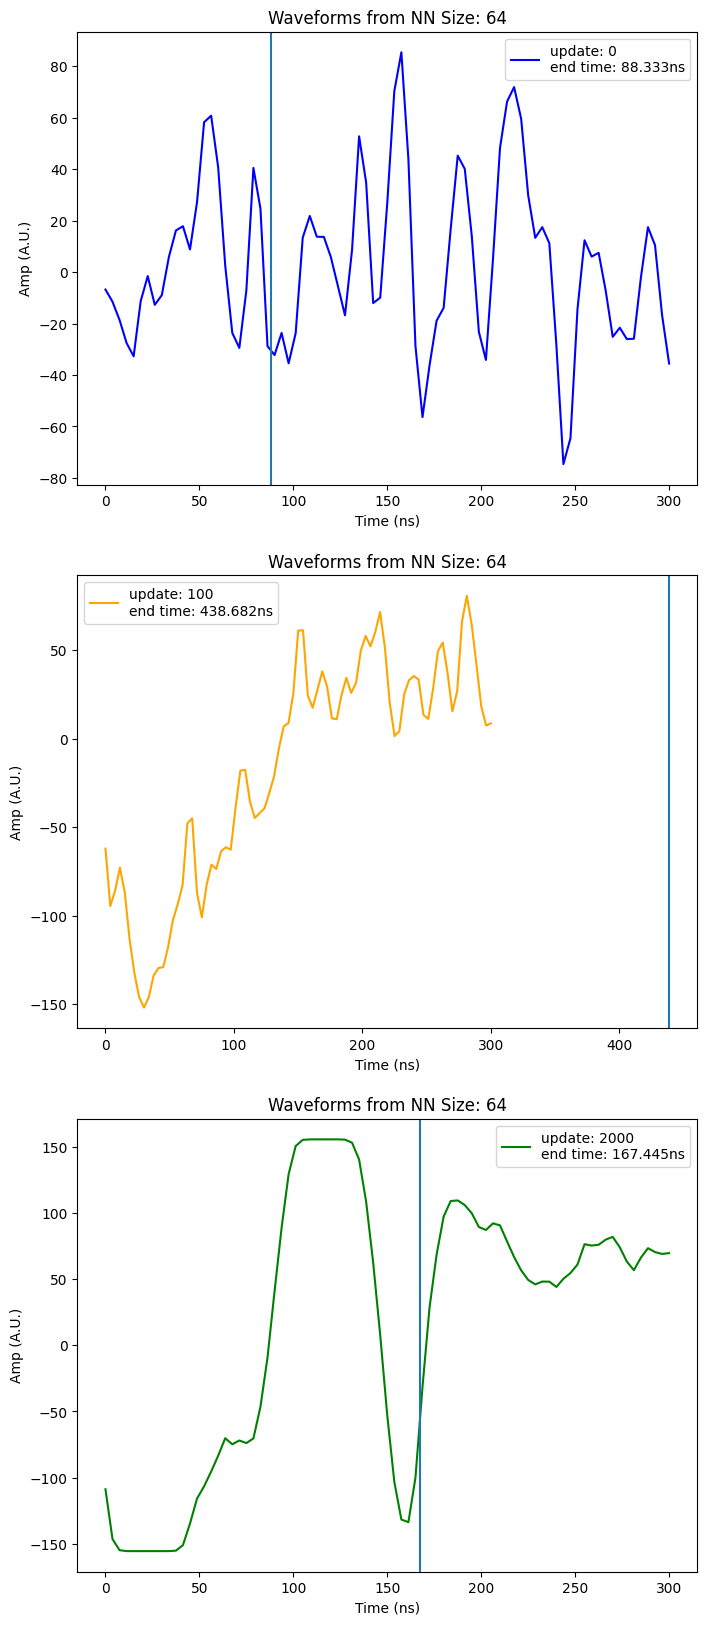

In [10]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()